In [1]:
import math
import matplotlib.pyplot as plt

In [2]:
class Corpus:
    def __init__(self, raw_corpus) -> None:
        self.raw_corpus = raw_corpus
        self.N = len(raw_corpus)
        self.doc_lengths = {doc: sum([raw_corpus[doc][word] for word in raw_corpus[doc]]) for doc in raw_corpus}
        self.avgdl = sum(list(self.doc_lengths.values())) / self.N
        self.inv_idx = {}
        for doc in raw_corpus:
            for word in raw_corpus[doc]:
                if word not in self.inv_idx:
                    self.inv_idx[word] = []
                self.inv_idx[word].append(doc)    
    def get_tf(self, doc, word):
        return self.raw_corpus[doc].get(word, 0)
    def get_df(self, word):
        return len(self.inv_idx[word])
    def get_dl(self, doc):
        return self.doc_lengths[doc]
    def get_avgdl(self):
        return self.avgdl
    def get_num_docs(self):
        return self.N
    def get_matching_docs(self, word):
        return self.inv_idx[word]
    def get_matching_docs_list(self, words):
        matching_docs = []
        for word in words:
            matching_docs += self.get_matching_docs(word)
        return list(set(matching_docs))
    def get_union_df(self, words):
        all_df = {}
        for word in words:
            for matching_doc in self.get_matching_docs(word):
                if matching_doc not in all_df:
                    all_df[matching_doc] = True
        return len(all_df)


In [4]:
def bm25(k1, b, query, corpus):
    """
    query is an array of terms
    e.g. ["w5", "w3"]
    """
    scores = {}
    for word in query:
        idf = math.log(corpus.get_num_docs() / corpus.get_df(word))
        candidate_documents = corpus.get_matching_docs(word)
        for doc in candidate_documents:
            if doc not in scores:
                scores[doc] = 0
            tf_num = (k1 + 1) * corpus.get_tf(doc, word)
            tf_denom = k1 * (1- b + b * (corpus.get_dl(doc) / corpus.get_avgdl())) + corpus.get_tf(doc, word)
            score = idf * (tf_num / tf_denom)
            scores[doc] += score
    return scores


def bm25s(k1, b, query, corpus):
    """
    query is a dictionary of list expansion terms
    e.g. {"w5": ["w3"]}
    """
    scores = {}

    for word in query:
        expansion_words = query[word]
        all_query_terms = expansion_words + [word] # add back the query term

        idf = math.log(corpus.get_num_docs() / corpus.get_union_df(all_query_terms))

        for doc in corpus.get_matching_docs_list(all_query_terms):
            if doc not in scores:
                scores[doc] = 0

                tf_across_expansions = 0
                for et in all_query_terms:
                    tf_across_expansions += corpus.get_tf(doc, et)

                tf_num = (k1 + 1) * tf_across_expansions
                tf_denom = k1 * (1- b + b * (corpus.get_dl(doc) / corpus.get_avgdl())) + tf_across_expansions

                score = idf * (tf_num / tf_denom)
                scores[doc] += score
    return scores
        

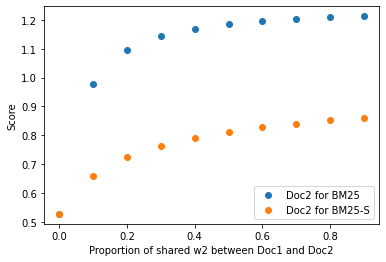

In [4]:
# Corpus simulations

"""
term in doc overlap
"""
scores = {
    "bm25": [],
    "bm25s": []
}
for i in range(10):
    raw_corpus = {
        "doc1": {"w1": 1, "w2": 10},
        "doc2": {"w1": 1, "w2": i},
        "doc3": {"w3": 1}
    }
    c = Corpus(raw_corpus)
    k1 = 1.5
    b = 0.5

    bm25_scores = bm25(1.5, 0.5, ["w1", "w2"], c)
    scores["bm25"].append({"percentage_overlap": i/10, "doc_scores": bm25_scores})

    bm25s_scores = bm25s(1.5, 0.5, {"w1": ["w2"]}, c)
    scores["bm25s"].append({"percentage_overlap": i/10, "doc_scores": bm25s_scores})

plt.scatter([x["percentage_overlap"] for x in scores["bm25"]], [x["doc_scores"]["doc2"] for x in scores["bm25"]], label='Doc2 for BM25')
plt.scatter([x["percentage_overlap"] for x in scores["bm25"]], [x["doc_scores"]["doc2"] for x in scores["bm25s"]],label='Doc2 for BM25-S')
plt.xlabel("Proportion of shared w2 between Doc1 and Doc2")
plt.ylabel("Score")
plt.legend()

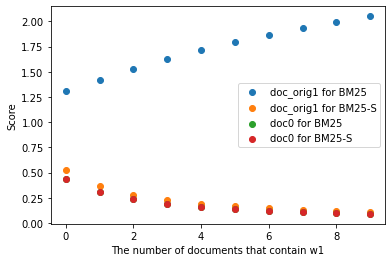

In [5]:
# high low union (number of docs)

# only adding docs with w1
# query: w1 and w2
# bm25 increases because w2 becomes more and more rare
# bm25s decreases because w1 exists in many docs, decreasing w2 importance

scores = {
    "bm25": [],
    "bm25s": []
}
raw_corpus = {
        "doc_orig1": {"w1": 1, "w2": 1},
        "doc_orig2": {"w3": 1}
    }
for i in range(10):
    raw_corpus["doc" + str(i)] = {"w1": 1}
    c = Corpus(raw_corpus)
    k1 = 1.5
    b = 0.5

    bm25_scores = bm25(1.5, 0.5, ["w1", "w2"], c)
    scores["bm25"].append({"num_overlap": i, "doc_scores": bm25_scores})


    bm25s_scores = bm25s(1.5, 0.5, {"w1": ["w2"]}, c)
    scores["bm25s"].append({"num_overlap": i, "doc_scores": bm25s_scores})

plt.scatter([x["num_overlap"] for x in scores["bm25"]], [x["doc_scores"]["doc_orig1"] for x in scores["bm25"]], label='doc_orig1 for BM25')
plt.scatter([x["num_overlap"] for x in scores["bm25"]], [x["doc_scores"]["doc_orig1"] for x in scores["bm25s"]],label='doc_orig1 for BM25-S')

# These are exactly the same
plt.scatter([x["num_overlap"] for x in scores["bm25"]], [x["doc_scores"]["doc0"] for x in scores["bm25"]], label='doc0 for BM25')
plt.scatter([x["num_overlap"] for x in scores["bm25"]], [x["doc_scores"]["doc0"] for x in scores["bm25s"]],label='doc0 for BM25-S')

plt.xlabel("The number of documents that contain w1")
plt.ylabel("Score")
plt.legend()

In [6]:
# Corpus parameters

# to Cheng
    # baseline, optimal v3 weight 1 bm25s, weight 1 bm25
# sanjeev: max,min idf and avg or union

# Cases where expansion term decreases score (idf drop)
# Many documents that do not match original query term

# Optimal expansion: gave bm25 favor, not matching any original query term
# union will decrease idf
# HYPOTHESIS: what should we expect in simulation? Under what conditions should bm25s outperform bm25
    # construct example scenarios
    # simulate relevance?
        # 
    # 1 query term, 1 expansion term, what do we expect in ranking results?
        # document matched both many
        # document matched original many, expansion few, and vice versa
        # just expansion term? over original match?
            # how to quantify these trade-offs?
        # how quickly does this change per expansion selection, broader corpus properties
        # query term, top n docs, label subset as relevant

    # also look at expansion terms in bm25, how it affects

    # pipeline: select expansion terms, record term statistics, retrieve, and compare term distributions in retireved ranked lists to find differences
        # inspire differences by axiomatic properties

import random

TOTAL_DOCS = 1000
TOTAL_WORDS = 100000
TOPICS = 100
MAX_DOC_LENGTH = 1000
raw_corpus ={}
for doc in range(TOTAL_DOCS):
    doc_length = random.randint(1,MAX_DOC_LENGTH)
    raw_corpus["doc" + str(doc)] = {}
    skip_interval = 1
    while doc_length > 0:
        word_selection = random.randint(skip_interval, min(skip_interval*2, TOTAL_WORDS))
        raw_corpus["doc" + str(doc)]["w" + str(word_selection)] = raw_corpus["doc" + str(doc)].get("w" + str(word_selection), 0) + 1
        skip_interval = skip_interval * 2
        if skip_interval > TOTAL_WORDS:
            skip_interval = 1
        doc_length -= 1

c = Corpus(raw_corpus)

In [8]:
scores = {
    "bm25": [],
    "bm25s": []
}

inv_idx = c.inv_idx
all_words = list(inv_idx.keys())

differences = {}

for i in range(500):
    base_query_word = all_words[random.randint(0, c.N)]
    exp_query_word1 = all_words[random.randint(0, c.N)]
    #exp_query_word2 = all_words[random.randint(0, c.N)]


    
    bm25_scores = bm25(1.5, 0.5, [base_query_word, exp_query_word1], c)
    scores["bm25"].append({"iteration": i, "query": [base_query_word, exp_query_word1], "doc_scores": bm25_scores})

    bm25s_scores = bm25s(1.5, 0.5, {base_query_word: [exp_query_word1]}, c)
    scores["bm25s"].append({"iteration": i, "query": {base_query_word: [exp_query_word1]}, "doc_scores": bm25s_scores})

    # Check the returned results, return the difference
    differences[i] = {}
    for rank,doc in enumerate(bm25_scores):
        differences[i][doc] = {"bm25": rank}
    for rank,doc in enumerate(bm25s_scores):
        if doc not in differences[i]:
            differences[i][doc] = {"bm25s": rank}
        else:
            differences[i][doc]["bm25s"] = rank

Text(0, 0.5, 'Proportion of documents ranked differently')

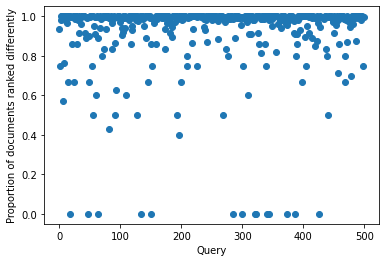

In [10]:
# num differences
num_diffs = []
for i in differences:
    num_diffs.append(0)
    for doc in differences[i]:
        if differences[i][doc]["bm25"] != differences[i][doc]["bm25s"]:
            num_diffs[i] += 1
    num_diffs[i] = num_diffs[i] / len(differences[i])

plt.scatter([i for i in range(len(num_diffs))], [i for i in num_diffs])
plt.xlabel("Query")
plt.ylabel("Proportion of documents ranked differently")


Text(0, 0.5, 'Proportion of documents moved from top-ten')

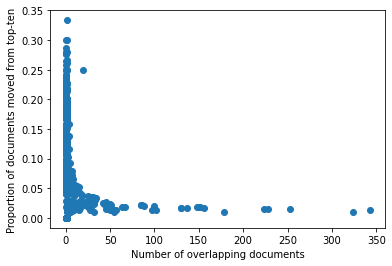

In [11]:
# changes within the top 10: documents that were in top ten of bm25, but no longer in bm25s top ten
# with respect to count of documents that contain both
num_diffs = []
matching_lengths = []
for i in differences:
    num_diffs.append(0)
    for doc in differences[i]:
        # check if there is a bm25 ranked doc inside top ten and bm25s ranked doc outside top ten
        if differences[i][doc]["bm25"] < 10 and differences[i][doc]["bm25s"] > 10:
            num_diffs[i] += 1
    num_diffs[i] = num_diffs[i] / len(differences[i])


    matching_length = len(list(set(c.get_matching_docs(scores["bm25"][i]["query"][0])).intersection(set(c.get_matching_docs(scores["bm25"][i]["query"][1])))))
    
    matching_lengths.append(matching_length)


plt.scatter(matching_lengths, num_diffs)
plt.xlabel("Number of overlapping documents")
plt.ylabel("Proportion of documents moved from top-ten")

In [12]:
# changes within the top n
all_doc_differences = {}
for i in differences:
    for doc in differences[i]:
        if doc not in all_doc_differences:
            all_doc_differences[doc] = {}
        difference = differences[i][doc]["bm25s"] - differences[i][doc]["bm25"]
        # note i is query id
        all_doc_differences[doc][i] = difference



In [54]:
reformatted = []
for doc in all_doc_differences:
    for queryid in all_doc_differences[doc]:
        reformatted.append({"doc": doc, "query": queryid, "delta": all_doc_differences[doc][queryid]})

reformatted = sorted(reformatted, reverse=True, key=lambda x: x["delta"])

In [55]:
reformatted[:10]

[{'doc': 'doc22', 'query': 160, 'delta': 961},
 {'doc': 'doc22', 'query': 339, 'delta': 958},
 {'doc': 'doc2', 'query': 160, 'delta': 956},
 {'doc': 'doc2', 'query': 339, 'delta': 953},
 {'doc': 'doc2', 'query': 3, 'delta': 938},
 {'doc': 'doc60', 'query': 160, 'delta': 913},
 {'doc': 'doc60', 'query': 339, 'delta': 909},
 {'doc': 'doc22', 'query': 69, 'delta': 907},
 {'doc': 'doc4', 'query': 160, 'delta': 905},
 {'doc': 'doc2', 'query': 69, 'delta': 902}]

In [56]:
current = reformatted[0]
print(raw_corpus[current["doc"]])
print(scores["bm25"][current["query"]]["query"])

{'w1': 4, 'w4': 5, 'w7': 4, 'w10': 2, 'w18': 2, 'w54': 1, 'w126': 1, 'w194': 1, 'w331': 1, 'w653': 1, 'w1870': 1, 'w2934': 1, 'w7076': 1, 'w8493': 1, 'w28776': 1, 'w50904': 1, 'w94143': 1, 'w2': 7, 'w13': 1, 'w24': 1, 'w59': 2, 'w109': 1, 'w179': 1, 'w376': 2, 'w848': 1, 'w1629': 1, 'w3555': 1, 'w6034': 1, 'w13004': 1, 'w30864': 1, 'w40663': 1, 'w87799': 1, 'w9': 2, 'w16': 2, 'w41': 1, 'w73': 1, 'w192': 1, 'w412': 1, 'w688': 1, 'w1771': 1, 'w2851': 1, 'w6281': 1, 'w14577': 1, 'w31986': 1, 'w42422': 1, 'w77969': 1, 'w121': 1, 'w128': 1, 'w619': 1, 'w1494': 1, 'w2897': 1, 'w7037': 1, 'w14390': 1, 'w21826': 1, 'w44032': 1, 'w99964': 1, 'w8': 1, 'w12': 1, 'w21': 1, 'w32': 2, 'w80': 1, 'w129': 1, 'w304': 1, 'w573': 1, 'w1045': 1, 'w2554': 1, 'w5230': 1, 'w13362': 1, 'w22311': 1, 'w47227': 1, 'w68983': 1, 'w5': 1, 'w14': 1, 'w19': 1, 'w50': 1, 'w115': 1, 'w171': 1, 'w366': 1, 'w700': 1, 'w1554': 1, 'w3213': 1, 'w7854': 1, 'w12783': 1, 'w23086': 1, 'w63593': 1, 'w69830': 1, 'w3': 2, 'w37': 1,